torch.Size([2, 28, 28])
ConvNet(
  (layer1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             816
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
 

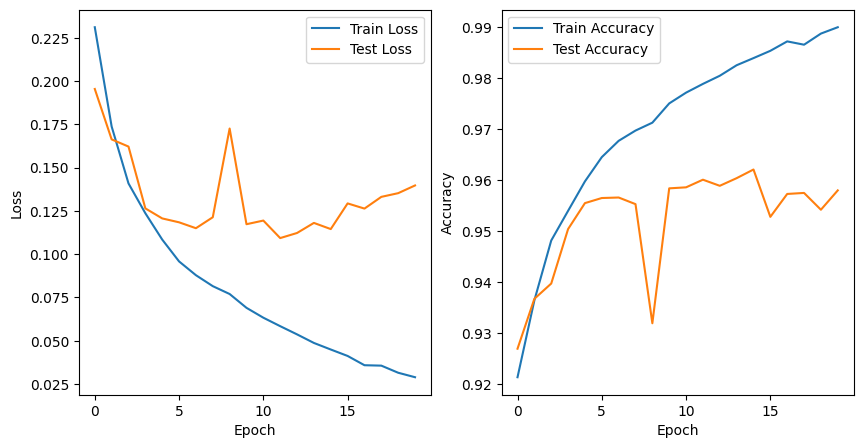

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchsummary import summary


mnist_train = dsets.MNIST(root='./data',
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

mnist_test = dsets.MNIST(root='./data',
                          train=False, 
                          transform=transforms.ToTensor())


def create_new_dataset(mnist_dataset):
    new_data = []
    new_labels = []
    for i in range(len(mnist_dataset)):
        
        idx1, idx2 = np.random.choice(len(mnist_dataset), 2)
        img1, label1 = mnist_dataset[idx1]
        img2, label2 = mnist_dataset[idx2]
        
        
        img1 = torch.squeeze(img1)
        img2 = torch.squeeze(img2)
        
        # 将两张图片拼接在一起
        new_img = torch.stack([img1, img2], dim=0)  
        
        
        new_label = 1 if label1 == label2 else 0
        
        new_data.append(new_img)
        new_labels.append(new_label)
    
    return new_data, new_labels

new_train_data, new_train_labels = create_new_dataset(mnist_train)
new_test_data, new_test_labels = create_new_dataset(mnist_test)
print(new_train_data[0].shape)


num_epochs = 20
batch_size = 100
learning_rate = 0.001


train_loader = torch.utils.data.DataLoader(dataset=list(zip(new_train_data, new_train_labels)),
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=list(zip(new_test_data, new_test_labels)),
                                          batch_size=batch_size, 
                                          shuffle=False)


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = ConvNet()

print(cnn)
summary(cnn,(2,28,28))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


train_losses = []
train_accs = []
test_losses = []
test_accs = []


for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    test_loss = 0
    test_correct = 0
    
    cnn.train()
   
    for images, labels in train_loader:
        images = Variable(images)
        labels = Variable(labels)
        
      
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_correct / len(train_loader.dataset))
    
    cnn.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = Variable(images)
            labels = Variable(labels)
            
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accs.append(test_correct / len(test_loader.dataset))
    
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1]))


# 初始化类别正确计数器
test_correct_class = [0, 0]
test_total_class = [0, 0]

cnn.eval()
# 测试阶段
with torch.no_grad():
    for images, labels in test_loader:
        images = Variable(images)
        labels = Variable(labels)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 计算每个类别的正确数
        for i in range(2):
            test_correct_class[i] += ((predicted == labels) & (labels == i)).sum().item()
            test_total_class[i] += (labels == i).sum().item()

# 打印每个类别的准确率
for i in range(2):
    print('Class {}: Test Acc: {:.4f} test_correct_class{:d}  test_total_class {:d}'
          .format(i, test_correct_class[i]/test_total_class[i],test_correct_class[i], test_total_class[i]))



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()